In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

Here we attempt solve following equation:

\begin{equation}
\partial_a\psi = i\kappa\frac{\nabla^2\psi}{a^3 \mathcal{H}}-i\frac{V\psi}{a^2\mathcal{H}}
\end{equation}
  
  where
  \begin{equation}
  \nabla^2V = \frac{1}{2\kappa}\left(|\psi|^2 -<|\psi|^2> \right)
  \end{equation}
with
\begin{equation}

\end{equation}

    
    
    
    
    

In [2]:
from GPE import GPE_scalar_field
from GPE import ImEx


In [9]:
#3-d Fiducial example

# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imC = np.array([2.0/11,289.0/462.0,751.0/924.0])

exC= np.array([0.0,5.0/6.0,11.0/12.0])


imx = ImEx(3,Ahat,A,bhat,b,imC,exC)
imx.cal_reg_of_stab()


def Hfunc(a,omega_m0,a0=1.0):
    return( np.sqrt(omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - omega_m0))    )


def rhs_f(u,xi2,kppa,a,da,s,omega_m0):
    
    u2 = np.square(np.abs(u))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape));
    
    
    ak = a+imx.im_C[s]*da
    H = Hfunc(ak,omega_m0)
    
    
    return (-1j*v*u/(ak*ak*H))

def im_rhs(psi_ft,xi2,kppa,a,da,s,omega_m0):
   
    psi_ft = -psi_ft*(xi2)
    ak = a+imx.ex_C[s]*da
    H = Hfunc(ak,omega_m0)
    return(1j*0.5*kppa*np.fft.ifftn(psi_ft,psi_ft.shape)/(ak*ak*ak*H))

    #return(0.0)

def calc_max_eig(u,xi2,kppa,a,omega_m0):
    
    u2 = np.square(np.abs(u))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape));
    H= Hfunc(a,omega_m0)
    mx = np.max(np.abs(v.real)/(a*a*H))
    
    return (mx)

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)



def solve_fdm_example(N,da):
    L = 1.0
    
    x = np.arange(-N/2,N/2)*(L/N)
    xv,yv,zv = np.meshgrid(x,x,x)
    xi = np.fft.fftfreq(N)*N*2*np.pi/L
    xix,xiy,xiz = np.meshgrid(xi,xi,xi)
    
    c_unit = 2.99
    hbar_unit = 6.582
    pc_unit = 3.086
    h = 0.67
    m_alpha = 0.175
    omega_m0 = 0.3
    ai = 0.0078125
    
    kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
    
   
   
    
   
    
   
    psl = np.reshape(np.genfromtxt("test_initial1.txt",usecols=(4,5)),(N,N,N,2))
    psi_ini = (psl[:,:,:,0]/100.0)+1j*(psl[:,:,:,1]/100.0)
    print(psi_ini.shape)
    
    

   
    print(type(psi_ini),psi_ini.shape,psi_ini.dtype)
    amax = 1.0

    

    num_plots = 50
    nplt = np.floor((amax/num_plots)/da)
    nmax = int(round(amax/da))
    print(nplt,"nmax",nmax)

    frames = [psi_ini.copy()]
    aa = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    

    
    
    psi = GPE_scalar_field(3,N,im_rhs,rhs_f,imx,psi_ini)
    xi2 = (xix*xix+xiy*xiy+xiz*xiz)
    lmbda_s = (0.5*kppa*xi2)
    
    u2 = np.square(np.abs(psi_ini))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*omega_m0)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,omega_m0));
    
    max_err = -1.0
    a = ai
        
    for n in range(nmax):
        
        #print(n)
        for k in range(imx.s):
            ak = a+imx.im_C[k]*da
            Hk = Hfunc(ak,omega_m0)
            lmbda = lmbda_s/(ak*ak*ak*Hk)
            
            psi.update_stage_sum(k,da)
            psi.do_fft(k,lmbda,da)
            psi.update_K(k,xi2,kppa,a,da,k,omega_m0)
            
            #max_egn = calc_max_eig(psi.psi,xi2,kppa,a,omega_m0)
            #print("maxeg*dt @ n",max_egn*da,n,k,imx.r_of_stb.imag)
        psi_tmp = psi.psi*1.0   
        psi.sum_contributions(da)
        
        
        a = ai+(n+1)*da
        
        max_egn = calc_max_eig(psi.psi,xi2,kppa,a,omega_m0)
        if((max_egn*da)>imx.r_of_stb.imag):
            print("maxeg*dt @ n",max_egn*da,n,k,imx.r_of_stb.imag)
            da  = 0.9*(imx.r_of_stb.imag/max_egn)
        
        
        
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi)
            aa.append(a)
           # err = sol_err(psi.psi,t,nx,T,max_err)
          #  err_l.append(err)
            
            mass = psi.calc_mass()
            mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            print(a,da)
            


   # err =  sol_err(psi.psi,t,nx,T,max_err)
  #  err_l.append(err)
            
    mass = psi.calc_mass()
    mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames, psi_tmp,psi.psi,v

In [ ]:

da = 0.001


frames,  psip,psic,v = solve_fdm_example(128,da)

(128, 128, 128)
<class 'numpy.ndarray'> (128, 128, 128) complex128
20.0 nmax 1000
class shapes (128, 128, 128) (3, 128, 128, 128)
(128, 128, 128) (128, 128, 128)


/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_26230/4027202720.py:127: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_26230/4027202720.py:127: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_26230/4027202720.py:26: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_26230/4027202720.py:26: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_26230/4027202720.py:50: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_26230/4027202720.py:50: RuntimeWarni

0.008812500000000001 0.001
0.0288125 0.001
0.0488125 0.001
0.0688125 0.001
0.0888125 0.001


In [117]:
ai = 0.0078125
omega_m0 = 0.3
c_unit = 2.99
hbar_unit = 6.582
pc_unit = 3.086
h = 0.67
m_alpha = 0.175
omega_m0 = 0.3
ai = 0.0078125
    
kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
print(0.5*kppa/(ai*ai*ai*Hfunc(ai,omega_m0)))

0.9650841359308788


In [106]:
psi

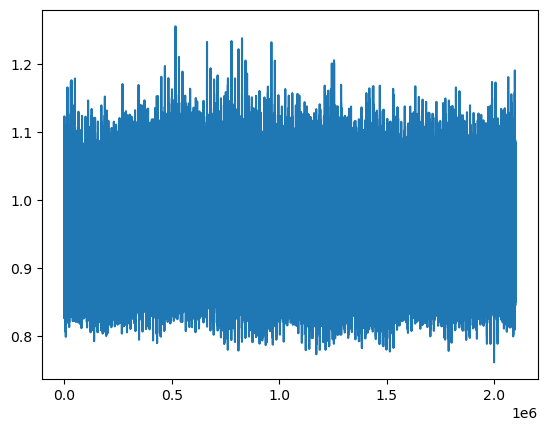

In [114]:
plt.plot(psip.flatten().real)


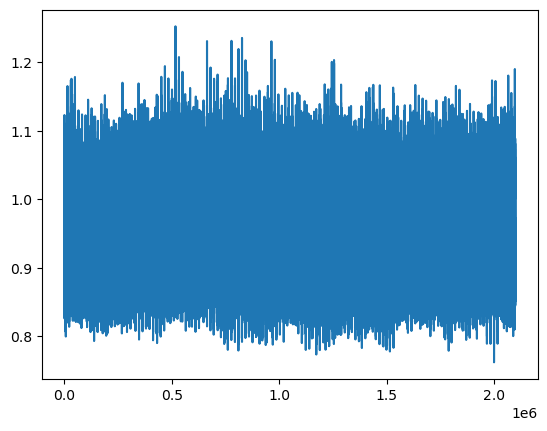

In [115]:
plt.plot(psic.flatten().real)

In [17]:
d2 = np.square(np.abs(psi_ini))
print(d2.shape)

(128, 128, 128)


In [18]:
d2 = d2/10000.0

In [19]:
dlt = d2.flatten()/(3.0*0.3)-1.0

In [20]:
dlt.shape

(2097152,)

In [21]:
dlt.sum()

-4.3141312744410243e-10

In [22]:
d.real

array([[103.02049518,  -1.25228466],
       [ 98.86225297,  -1.17613939],
       [ 96.26808953,  -1.12063124],
       ...,
       [103.57740649,  -1.60874772],
       [108.51031287,  -1.53114843],
       [108.00033975,  -1.42282909]])